In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

#% matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv("../input/tweet-sentiment-extraction/train.csv",header = None ,names=['sentence_source', 'sentence', 'label_notes' , 'label',])

In [3]:
df = df[:100]
df = df.drop(0,axis=0)
print(df.head())

  sentence_source                                           sentence  \
1      cb774db0d1                I`d have responded, if I were going   
2      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
3      088c60f138                          my boss is bullying me...   
4      9642c003ef                     what interview! leave me alone   
5      358bd9e861   Sons of ****, why couldn`t they put them on t...   

                           label_notes     label  
1  I`d have responded, if I were going   neutral  
2                             Sooo SAD  negative  
3                          bullying me  negative  
4                       leave me alone  negative  
5                        Sons of ****,  negative  


In [4]:
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 
  
df['label']= le.fit_transform(df['label']) 
#data['Geography']= le.fit_transform(data['Geography']) 

In [5]:
print(len(df))
print(df.head())

99
  sentence_source                                           sentence  \
1      cb774db0d1                I`d have responded, if I were going   
2      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
3      088c60f138                          my boss is bullying me...   
4      9642c003ef                     what interview! leave me alone   
5      358bd9e861   Sons of ****, why couldn`t they put them on t...   

                           label_notes  label  
1  I`d have responded, if I were going      1  
2                             Sooo SAD      0  
3                          bullying me      0  
4                       leave me alone      0  
5                        Sons of ****,      0  


In [6]:
# Create sentence and label lists
#sentences = str(df.sentence)
sentences = df.sentence.values
#print(len(sentences))
#sentences = str(sentences)
#print(len(sentences))

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df.label.values
print(len(sentences))

99


In [7]:
print(len(sentences))
print(len(labels))

99
99


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 674300.47B/s]


Tokenize the first sentence:
['[CLS]', 'i', '`', 'd', 'have', 'responded', ',', 'if', 'i', 'were', 'going', '[SEP]']


In [9]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [10]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [11]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [12]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [13]:
print(len(input_ids))
print(len(labels))

99
99


In [14]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [15]:
print(type(train_labels[0]))

<class 'numpy.int64'>


In [16]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [17]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [18]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
#model.cuda()

100%|██████████| 407873900/407873900 [00:16<00:00, 24386087.92B/s]


In [19]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [20]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [21]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#n_gpu = torch.cuda.device_count()
#torch.cuda.get_device_name(0)

In [23]:
#print(b_labels)
from keras.utils import to_categorical
labels = to_categorical(labels)

In [24]:
print(labels)

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1.

In [25]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.0983026226361592


Epoch:  25%|██▌       | 1/4 [00:55<02:45, 55.29s/it]

Validation Accuracy: 0.4
Train loss: 1.0273603399594624


Epoch:  50%|█████     | 2/4 [01:44<01:46, 53.46s/it]

Validation Accuracy: 0.4
Train loss: 0.9522969027360281


Epoch:  75%|███████▌  | 3/4 [02:33<00:52, 52.27s/it]

Validation Accuracy: 0.4
Train loss: 0.6667760014533997


Epoch: 100%|██████████| 4/4 [03:23<00:00, 50.95s/it]

Validation Accuracy: 0.6


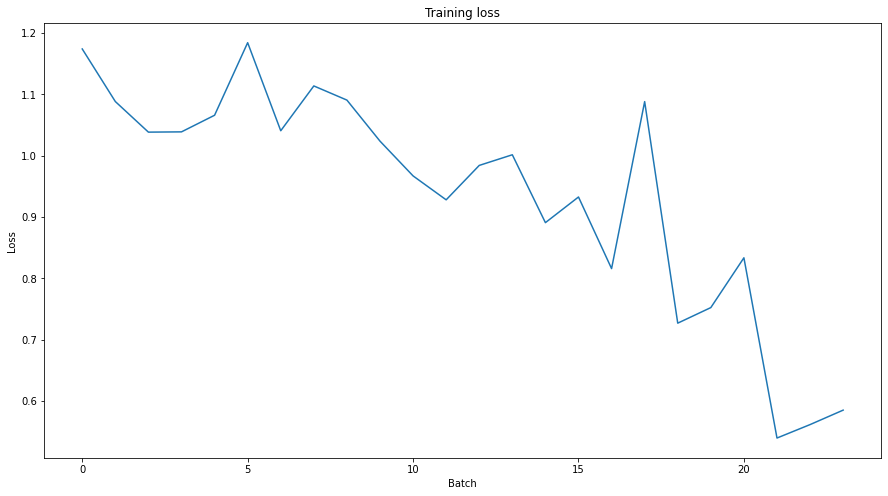

In [26]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [27]:
df = pd.read_csv("../input/tweet-sentiment-extraction/train.csv", header=None, names=['sentence_source', 'sentence' , 'label',])
df = df[:100]
print(df.head())
df = df.drop('textID',axis=0)
df['label']= le.fit_transform(df['label']) 

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
labels = to_categorical(labels)
prediction_labels = torch.tensor(labels)
  
batch_size = 16  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

                                           sentence_source  \
textID                                                text   
cb774db0d1             I`d have responded, if I were going   
549e992a42   Sooo SAD I will miss you here in San Diego!!!   
088c60f138                       my boss is bullying me...   
9642c003ef                  what interview! leave me alone   

                                       sentence      label  
textID                            selected_text  sentiment  
cb774db0d1  I`d have responded, if I were going    neutral  
549e992a42                             Sooo SAD   negative  
088c60f138                          bullying me   negative  
9642c003ef                       leave me alone   negative  


In [28]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [29]:
print(predictions)

[array([[-1.1301969 ,  2.172469  , -1.7636843 ],
       [ 0.576825  , -1.0220141 ,  0.47658223],
       [ 0.52647305, -0.39887542, -0.09608044],
       [ 0.8118061 , -0.5067036 , -0.20500767],
       [ 0.62752086, -1.1408031 ,  0.6935668 ],
       [-0.85454583,  2.1429324 , -1.36687   ],
       [ 0.3513953 , -0.89898384,  0.6189303 ],
       [ 0.6121655 , -0.9942755 ,  0.48420647],
       [-0.96257395,  1.9779321 , -1.3440657 ],
       [ 0.59318256, -1.0692194 ,  0.6335727 ],
       [-1.1445782 ,  2.1919043 , -1.7365451 ],
       [ 0.58345425, -0.3132704 , -0.00291499],
       [ 0.59075564, -0.8517146 ,  0.23350903],
       [-0.37777478,  0.462009  , -0.50301766],
       [-0.99179316,  1.8533304 , -1.5728561 ],
       [ 0.7614185 , -1.1087052 ,  0.39870912]], dtype=float32), array([[ 0.6789026 , -1.0676562 ,  0.47533095],
       [ 0.75290877, -0.99864805,  0.22453454],
       [-0.5092921 ,  0.6384009 , -0.43753296],
       [-0.9650298 ,  2.1080816 , -1.4324907 ],
       [-1.0002995 ,  

In [32]:
x = predictions[0][0]

In [33]:
print(x)

[ 0.576825   -1.0220141   0.47658223]


In [34]:
print(np.argmax(x))

0
